# Advanced Machine Learning (MScA, 32017)

# Project: Paraphrase Detection

# Part 2: Solution by recurrent neural network

### Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2017

Keras provides tools for Natural Language Processing including preprocessing text and working with pre-trained word embeddings. The goal of this notebook is to describe those tools and to give some basic examples of using them.

# Tools for Preprocessing Text


## Text_to_word_sequence

Function   

*text_to_word_sequence(text, filters,lower=True,split=" ")*  

splits a sentence into a list of words. The arguments are

- *text*: string.
- *filters*: list (or concatenation) of characters to filter out, such as punctuation. Default: 

'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n' , includes basic punctuation, tabs, and newlines.

- *lower*: boolean. Whether to set the text to lowercase.
- *split*: string. Separator for word splitting.

Apply it to Quora questions

In [1]:
%matplotlib inline
from keras.preprocessing.text import text_to_word_sequence, one_hot, Tokenizer 
import pandas as pd
import os
import numpy as np


dataPath = "./data/"
train = pd.read_csv(dataPath+'quora_train_1000.csv',usecols=['question1','question2'])
train.dropna(inplace=True) # remove two rows as in NLP feature creation
train = train[:1000] # only for demo and testing, comment out with complete data
question = train.question1[0]
print(question)
print(text_to_word_sequence(question))

Using TensorFlow backend.


What is the step by step guide to invest in share market in india?
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india']


In [2]:
train.head()

,question1,question2
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [3]:
train.shape

(1000, 2)

## One_hot

Function   

*one_hot(text,n,filters,lower=True,split=" ")*.    

One-hot encodes a text into a list of numeric indices corresponding to words in a vocabulary of size n. <br>
Returns list of integers in [1, n]. Each integer encodes a word (uniqueness non-guaranteed).  
Integer *n* is vocabulary size, i.e. the number of different hash fields in the vocabulary. <br>
Other parameters are the same as in *text_to_word_sequence*.

In spite of the name it is **not one-hot**, the function actually implements [**hashing trick**](http://alex.smola.org/papers/2009/Weinbergeretal09.pdf) using *hash()* function. 

Hashing trick is named in association with kernel trick, but the way it works is in some sence opposite:

- Kurnel trick expands dimensionality of the space in order to find a separating hyperplane;
- Hashing trick reduces dimensionality by assigning a relatively small fixed number of hash labels to a multidimensional objects, like bag-of-words object.

Here is an example.

Apply one-hot to a simple sentence and see how hashing depends on the size of vocabulary.

In [4]:
myText=text_to_word_sequence('I love data')
print(question)
for i in range(2,10,1):
        print(one_hot('I love data',i))

What is the step by step guide to invest in share market in india?
[1, 1, 1]
[1, 2, 2]
[3, 2, 2]
[3, 4, 4]
[2, 4, 4]
[3, 2, 2]
[6, 6, 2]
[7, 4, 8]


Note **collisions**, i.e. same hashes assigned to different words. <br>
Collisions reduce accuracy of classification, but not as much as it might seem: in [this article](http://hunch.net/~jl/projects/hash_reps/hash_kernels/hashkernel.pdf) authors described an experiment in which they observed collision rate of 94% (94% of features mapped to the same index as one or more other features) resulting in an increase in the experimental error rate from 5.5% to only 6%.

Apply one-hot to the one of the questions. Use vocabulary of sizes 5 and 1000.

In [6]:
print(question)
print(len(set(text_to_word_sequence(question))),'unique words')
print(one_hot(question,5),len(set(one_hot(question,5))))
print(one_hot(question,1000),len(set(one_hot(question,1000))))

What is the step by step guide to invest in share market in india?
12 unique words
[3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2] 3
[608, 709, 933, 959, 241, 959, 134, 345, 956, 59, 902, 204, 59, 212] 12


Note that with larger hash encoding is more likely unique.

## Tokenizer

Class  

*Tokenizer(num_words=None,filters,lower=True,split=" ",char_level=False)*  

is designed for vectorizing texts, and/or turning texts into numeric sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).

Arguments *filters, lower, split* are the same as in *text_to_word_sequence* above.

- num_words: None or integer. Maximum number of words to work with (if set, tokenization will be restricted to the top num_words most common words in the dataset).
- char_level: if True, every character will be treated as a token.  

Method *fit_on_texts* takes the list of texts for training on as argument. <br>
After *fit_on_texts* call class object has the following attrubutes:  

- *word_counts*: dictionary mapping words (str) to their appearance number.
- *word_docs*: dictionary mapping words (str) to the number of documents/texts in which they appeared.
- *word_index*: dictionary mapping words (str) to their rank/index (int).
- *document_count*: int. Number of documents (texts/sequences) the tokenizer was trained on.

 Apply *fit_on_texts* to the pair of questions and look at the  returned object attributes.

In [12]:
texts = [train.question1[7],train.question2[7]]
print(texts[0])
print(texts[1])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
for attr in ['word_index','word_counts','word_docs','document_count']:
    print(attr, '=', vars(tokenizer)[attr])

How can I be a good geologist?
What should I do to be a great geologist?
word_index = {'i': 1, 'be': 2, 'a': 3, 'geologist': 4, 'how': 5, 'can': 6, 'good': 7, 'what': 8, 'should': 9, 'do': 10, 'to': 11, 'great': 12}
word_counts = OrderedDict([('how', 1), ('can', 1), ('i', 2), ('be', 2), ('a', 2), ('good', 1), ('geologist', 2), ('what', 1), ('should', 1), ('do', 1), ('to', 1), ('great', 1)])
word_docs = {'i': 2, 'can': 1, 'how': 1, 'geologist': 2, 'good': 1, 'a': 2, 'be': 2, 'should': 1, 'do': 1, 'great': 1, 'to': 1, 'what': 1}
document_count = 2


## Texts_to_sequences

Method  

*texts_to_sequences(texts)* 

transforms list of texts to list of sequences (one per text input).

In [13]:
tokenizer.texts_to_sequences(texts)

[[5, 6, 1, 2, 3, 7, 4], [8, 9, 1, 10, 11, 2, 3, 12, 4]]

Each word is replaced with its index in *word_index*.  

Method 

*texts_to_matrix(texts)*  

can be used to create one vector per document in *texts*.  <br>
Length of vector is the total size of the vocabulary. <br>
So, method returns numpy array of shape (len(texts), len(tokenizer.word_index)+1).

In default "binary" mode the vector component equals 0 if there is no such word in the document.

In [26]:
print(texts)
print(tokenizer.texts_to_matrix(texts))

['How can I be a good geologist?', 'What should I do to be a great geologist?']
[[ 0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.]]


Modes "count", "tfidf" and "freq" are also available.

Note that *texts_to_matrix* does not fit texts. It uses results of *fit_on_texts* call. In the example below we get zero vectors since selected questions have no words common with *texts* above.

In [14]:
texts1 = [train.question1[4],train.question1[4]]
print(texts1)
print(tokenizer.texts_to_matrix(texts1))

['Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?', 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?']
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Embedding layer

There is special layer in Keras designed to work with or without pre-trained embeddings or mappings of numbers from some vocabulary to vectors of real numbers:  

*keras.layers.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)*  

This layer turns positive integers (usually word indexes in a dictionary) into dense vectors of fixed size. This layer can only be used as the first layer in a model. 

The list of arguments that will be used:

- *input_dim*: int > 0. Size of the vocabulary, i.e. maximum size of dictionary.
- *output_dim*: int >= 0. Dimension of the dense embedding.
- *input_length*: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).  

Below is the example of small sequential network with not pre-trained embedding layer. 

The largest integer (i.e. word index) in the input should not be larger than 999 (vocabulary size). 

Now model.output_shape == (None, 10, 64), where None is the batch dimension.

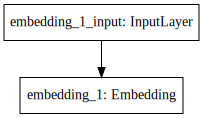

In [15]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = Sequential()
# vocabulary of 7, giving vector of length 5, expect back matrix of 5x2
model.add(Embedding(input_dim=7, output_dim=2, input_length=5))

SVG(model_to_dot(model).create(prog='dot', format='svg'))

This network consists of embedding layer. <br>

It takes as input a numeric tensor of shape (None,input_length) and the first dimension of tensor shape is not specified ahead of time. <br>

The output is a tensor with shape (None,input_length,output_dim) which is created by associating each number of the input with a vector of length *output_dim* based on the dictionary of length *input_dim* of vectors of length *output_dim*, i.e.dictionary has dimensions (input_dim,output_dim). <br>

Dictionaly may be provided or not. Embedding layer may be trained or just use provided dictionary. <br>
Trained weights have dimension (input_dim,output_dim).

Print summary of the layer.

In [18]:
print(model.summary())
embeddingWeights=model.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 2)              14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None


Weights in this example are not trained, but randomly selected.

In [19]:
embeddingWeights

[array([[ 0.00404574,  0.04395901],
        [-0.01903176,  0.00661968],
        [-0.04307199, -0.03223918],
        [-0.04035587,  0.03969958],
        [ 0.02194336,  0.03976114],
        [ 0.01879166,  0.00146125],
        [ 0.04085871, -0.01919118]], dtype=float32)]

In [20]:
input_array = np.random.randint(5, size=(1, 5))
print(input_array)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
output_array

[[0 0 1 2 0]]


array([[[ 0.00404574,  0.04395901],
        [ 0.00404574,  0.04395901],
        [-0.01903176,  0.00661968],
        [-0.04307199, -0.03223918],
        [ 0.00404574,  0.04395901]]], dtype=float32)

Observe how output array is created from the input and the matrix of weights: rows of output are arrays assigned to each element of the input.

In [21]:
embeddingWeights=embeddingWeights[0]+1

In [22]:
model1 = Sequential()
model1.add(Embedding(input_dim=7,weights=[embeddingWeights], output_dim=2, input_length=5))
SVG(model_to_dot(model1).create(prog='dot', format='svg'))
model1.compile('rmsprop', 'mse')
output_array = model1.predict(input_array)
print('Weights set to:')
print(model1.get_weights())
print('Output is:')
output_array

Weights set to:
[array([[ 1.00404572,  1.04395902],
       [ 0.98096824,  1.00661969],
       [ 0.95692801,  0.9677608 ],
       [ 0.95964414,  1.03969955],
       [ 1.02194333,  1.03976119],
       [ 1.01879168,  1.00146127],
       [ 1.04085875,  0.98080879]], dtype=float32)]
Output is:


array([[[ 1.00404572,  1.04395902],
        [ 1.00404572,  1.04395902],
        [ 0.98096824,  1.00661969],
        [ 0.95692801,  0.9677608 ],
        [ 1.00404572,  1.04395902]]], dtype=float32)

In Quora project embedding layer will take as input sequence of word indices in a vocabulary and return a vector of fixed length for each index according to a specially trained matrix.  

## LTSM layer

LSTM networks belong to a type of recurrent neural network capable of learning order dependence in sequence prediction problems. 

Here is an excellent post: [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/). 

### Regression example of LSTM model

In this example create model with 1 LSTM layer to predict next value of a sequence of points taken from the curve shown on the following graph.

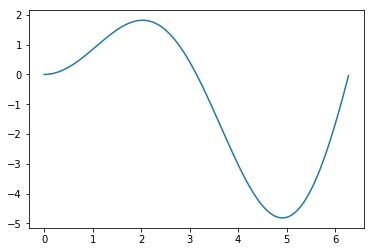

In [23]:
%matplotlib inline
import numpy as np
from keras.layers import Dense, Activation, LSTM, Input
from keras.models import Sequential, Model
from keras.optimizers import Adagrad, adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



N = 1000
H = 2*np.pi/N
t = H*np.arange(N)
X = np.sin(t)*t

plt.plot(t,X)


Generate the data

In [36]:
look_back = 6
start = np.arange(N-look_back-1) # indexes of the sequence beginnig
target = X[start+look_back]  # values to be predicted
data = np.array([X[i:(i+look_back)] for i in start]) 

Expected LSTM input data shape is 

*(batch_size, timesteps, data_dim)*, 

where *timesteps* is the number of sequences in one sample. 

We have only 1 sequence in this example, so reshape input data accordingly

In [42]:
print('before',data.shape)
data = np.reshape(data, (data.shape[0], 1, look_back))
print('after',data.shape)

before (993, 6)
after (993, 1, 6)


Keras constuctor for [LSTM layer](https://keras.io/layers/recurrent/) has more than 20 arguments. 

For simplicity we list only fewcarguments recommended for this project:
 
`keras.layers.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.0, recurrent_dropout=0.0, ...)`

- units: Positive integer, dimensionality of the output space.
- activation: Activation function to use (see activations). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
- recurrent_activation: Activation function to use for the recurrent step (see activations).
- dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
- recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.
- ...: additional omitted parameters

The following function creates simple LSTM network using functional API.

In [43]:
def LSTM_model(neurons):
    # neurons: positive integer
    input = Input(shape=(1, look_back))
    x = LSTM(neurons)(input)
    output = Dense(1, activation='linear')(x)
    model = Model(inputs=input, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

model = LSTM_model(4)

Print the model by either *'SVG'* or *'plot_model'*

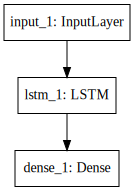

In [44]:
plot_model(model, to_file='LSTM_ex1.png',show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Plotting model from the saved file.
![LSTM_ex1](./LSTM_ex1.png)  

Define *EarlyStopping* callback and fit the model.

In [45]:
valid_size = 0.2 # splitting into train and test
early_stopping = EarlyStopping(monitor="val_loss", patience=1)

hist = model.fit(data,target,epochs=100,validation_split = valid_size,
          callbacks=[early_stopping],verbose=2)
print('LSTM : loss = ',min(hist.history['val_loss']),' epochs =',
      len(hist.history['val_loss']))

Train on 794 samples, validate on 199 samples
Epoch 1/100
1s - loss: 3.8956 - val_loss: 8.3680
Epoch 2/100
0s - loss: 3.6381 - val_loss: 8.0416
Epoch 3/100
0s - loss: 3.4581 - val_loss: 7.7786
Epoch 4/100
0s - loss: 3.3105 - val_loss: 7.4804
Epoch 5/100
0s - loss: 3.1295 - val_loss: 7.0428
Epoch 6/100
0s - loss: 2.9268 - val_loss: 6.5683
Epoch 7/100
0s - loss: 2.7311 - val_loss: 6.1272
Epoch 8/100
0s - loss: 2.5537 - val_loss: 5.7575
Epoch 9/100
0s - loss: 2.4051 - val_loss: 5.4498
Epoch 10/100
0s - loss: 2.2840 - val_loss: 5.2004
Epoch 11/100
0s - loss: 2.1737 - val_loss: 4.9653
Epoch 12/100
0s - loss: 2.0684 - val_loss: 4.7414
Epoch 13/100
0s - loss: 1.9661 - val_loss: 4.5363
Epoch 14/100
0s - loss: 1.8705 - val_loss: 4.3342
Epoch 15/100
0s - loss: 1.7807 - val_loss: 4.1478
Epoch 16/100
0s - loss: 1.6998 - val_loss: 3.9624
Epoch 17/100
0s - loss: 1.6228 - val_loss: 3.7924
Epoch 18/100
0s - loss: 1.5524 - val_loss: 3.6234
Epoch 19/100
0s - loss: 1.4848 - val_loss: 3.4654
Epoch 20/100


Keras does not shuffle the data in validation process. It just takes the end of the data for validation. <br>
Make prediction of the part of the data that was not used in training

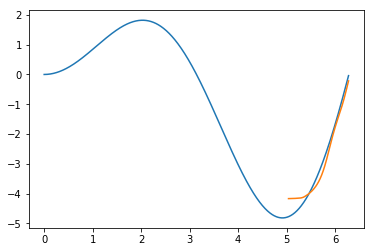

In [46]:
valid_dim = int(valid_size*data.shape[0])  # number of validation samples
plt.plot(t,X)
y = model.predict(data[-valid_dim:,:,:])
plt.plot(t[-valid_dim:],y)

In order to improve prediction quality increase number of neurons in LSTM layer to 20.

LSTM : loss =  0.0434727902856  epochs = 59


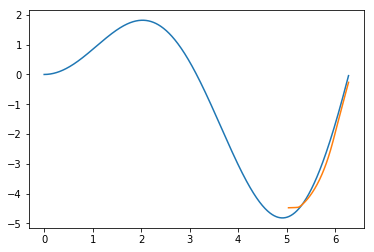

In [48]:
model = LSTM_model(10)
hist = model.fit(data,target,epochs=100,validation_split = valid_size,
          callbacks=[early_stopping],verbose=0)
print('LSTM : loss = ',min(hist.history['val_loss']),' epochs =',
      len(hist.history['val_loss']))
plt.plot(t,X)
y = model.predict(data[-valid_dim:,:,:])
plt.plot(t[-valid_dim:],y)

With increased number of neurons RMSE is better. 

Increase number of neurons to 50 and check the results again.

LSTM : loss =  0.0728891554977  epochs = 5


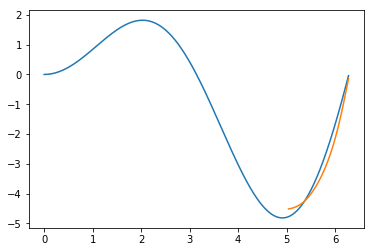

In [47]:
model = LSTM_model(50)
hist = model.fit(data,target,epochs=100,validation_split = valid_size,
          callbacks=[early_stopping],verbose=0)
print('LSTM : loss = ',min(hist.history['val_loss']),' epochs =',
      len(hist.history['val_loss']))
plt.plot(t,X)
y = model.predict(data[-valid_dim:,:,:])
plt.plot(t[-valid_dim:],y)

More neurons does not always mean better.

# Steps of Preprocessing

Description of all Keras tools necessary for converting questions into additional useful features for neural network is over. 

Now go through the several following steps of processing questions. 

## Step 1. Lemmatization

Questions are preprocessed so that the different forms of writing the same text (like "don't" and "do not") are  matched. Lemmatization similar to one done in the first part of the project helps again. 

Lemmatize with *WordNetLemmatizer*:

In [49]:
from nltk.stem.wordnet import WordNetLemmatizer
WNL = WordNetLemmatizer()

def cutter(word):
    if len(word) < 4:
        return word
    return WNL.lemmatize(WNL.lemmatize(word, "n"), "v")

Function *'cutter()'* lemmatizes words to standardized form.

In [50]:
cutter('visualizing')

'visualize'

Here is one of preprocessing transformations of questions suggested during Kaggle competition.

In [52]:
import re
def preprocess(string):
    # standardize expression with apostrophe, replace some special symbols with word
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    # remove punctuation and special symbols
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    # lemmatize
    string = ' '.join([cutter(w) for w in string.split()])
    return string

Apply preprocessing to train sample. 

All transformations applied to train should be applied to test too.

In [57]:
print('Question 1: %s' % train["question1"][1])
print('Question 2: %s' % train["question2"][1])
train["question1"] = train["question1"].fillna("").apply(preprocess)
train["question2"] = train["question2"].fillna("").apply(preprocess)
print('Question 1 processed: %s' % train.question1[1])
print('Question 2 processed: %s' % train.question2[1])

Question 1: what is the story of kohinoor koh i noor diamond
Question 2: what would happen if the indian government steal the kohinoor koh i noor diamond back
Question 1 processed: what is the story of kohinoor koh i noor diamond
Question 2 processed: what would happen if the indian government steal the kohinoor koh i noor diamond back


In [63]:
pd.Series(train["question1"].tolist() + train["question2"].tolist())

0       what is the step by step guide to invest in sh...
1        what is the story of kohinoor koh i noor diamond
2       how can i increase the speed of my internet co...
3        why am i mentally very lonely how can i solve it
4       which one dissolve in water quikly sugar salt ...
5       astrology i am a capricorn sun cap moon and ca...
6                                      should i buy tiago
7                           how can i be a good geologist
8                          when do you use シ instead of し
9       motorola company can i hack my charter motorol...
10      method to find separation of slit use fresnel ...
11              how do i read and find my youtube comment
12                     what can make physic easy to learn
13             what was your first sexual experience like
14      what are the law to change your status from a ...
15      what would a trump presidency mean for current...
16                             what doe manipulation mean
17      why do

## Step 2. Creating vocabulary of frequent words

Create vocabulary of relatively frequent words in questions: words with frequency greater than *MIN_WORD_OCCURRENCE* times. 

For the small dataset *MIN_WORD_OCCURRENCE* is selected small, but for the whole dataset it should be much larger (may be in the range 50-150).

For word count use familiar *CountVectorizer*.

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

MIN_WORD_OCCURRENCE = 3 # 3 for demo and testing in local environment. Select number for final results

all_questions = pd.Series(train["question1"].tolist() + train["question2"].tolist()).unique()
vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", # replace white spaces with spaces
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(all_questions)
top_words = set(vectorizer.vocabulary_.keys())
print(len(top_words),'top_words')
print('Top words %s' % list(top_words)[:10])

1019 top_words
Top words ['try', 'relationship', 'love', 'got', 'youtube', 'screen', 'too', 'join', 'delete', 'hillary']


## Step 3. Remove rare words

The consecutive rare words are replaced with one word "suspense" (you may try another replacement). The result is limited to 30 trailing words. 

Remove first words in long question since the end of it is usually more important. 

Add "suspense" to *top_words*.

In [65]:
REPLACE_WORD = "suspense"
top_words.add(REPLACE_WORD)
MAX_SEQUENCE_LENGTH = 30

In [66]:
def prepare(q):
    new_q = []
    new_suspense = True # ready to add REPLACE_WORD 
    # a[::-1] invert order of list a, so we start from the end
    for w in q.split()[::-1]:
        if w in top_words:
            new_q = [w] + new_q # add word from top_words
            new_suspense = True
        elif new_suspense:
            new_q = [REPLACE_WORD] + new_q
            new_suspense = False  # only 1 REPLACE_WORD for group of rare words
        if len(new_q) == MAX_SEQUENCE_LENGTH:
            break
    new_q = " ".join(new_q)
    return new_q

question = train.question1[9]
print('Question: %s' % question)
print('Prepared question: %s' % prepare(question))

Question: motorola company can i hack my charter motorolla dcx3400
Prepared question: suspense company can i hack my suspense


Apply the function to train questions

In [67]:
q1s_train = train.question1.apply(prepare)
q2s_train = train.question2.apply(prepare)
print(q1s_train[0])

what is the step by step suspense to invest in share market in india


## Step 4. Create embedding index

Build embedding index - dictionary with words from *top_words* as keys and their vector presentations as values.

Take vector presentations of words from Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) embedding file [glove.840B.300d](http://nlp.stanford.edu/data/glove.840B.300d.zip). Each line of the file contains word space separated from components of word vector.

In [70]:
EMBEDDING_DIM = 300
EMBEDDING_FILE = "glove.840B.300d.txt"

def get_embedding():
    embeddings_index = {}
    with open(EMBEDDING_FILE, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if len(values) == EMBEDDING_DIM + 1 and word in top_words:
                coefs = np.asarray(values[1:], dtype="float32")
                embeddings_index[word] = coefs
    return embeddings_index

Build *embeddings_index* and reduce *top_words* to those having vector representation.

In [71]:
embeddings_index = get_embedding()
print("Words not found in the embedding:", top_words - embeddings_index.keys())
top_words = embeddings_index.keys()

Words not found in the embedding: {'rohingya'}


## Step 5. Transform questions into integer valued sequences of equal lengths

It is described above how *Tokenizer.texts_to_sequences* converts question to a list of integers. 

But such lists may have different lengths for different questions. 

Keras provides method for fixing this issue:

*keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.)* 

It transforms a list of *num_samples* sequences (lists of scalars) into a 2D Numpy array of shape 

*(num_samples, num_timesteps)*, 

where *num_timesteps* is either *maxlen* argument (if provided), or the length of the longest sequence.

Sequences that are shorter than *num_timesteps* are padded with *value* at the end. Sequences longer than *num_timesteps* are truncated so that they have the desired length. 

Position where padding or truncation happens is determined by *padding* or *truncating*, respectively.

Here are several examples

In [72]:
from keras.preprocessing.sequence import pad_sequences
sequences = [[1,2],[1,2,3,4,5]]
print('Original sequences: %s' % sequences)
print('Padded default: %s' % pad_sequences(sequences))
print('Padded with maxlen=4: %s' % pad_sequences(sequences,maxlen=4))
print('Padded with maxlen=4, padding=post: %s' % pad_sequences(sequences,maxlen=4,padding='post'))
print('Padded with maxlen=4, padding=post, truncating=post: %s' \
      %pad_sequences(sequences,maxlen=4,padding='post',truncating='post'))

Original sequences: [[1, 2], [1, 2, 3, 4, 5]]
Padded default: [[0 0 0 1 2]
 [1 2 3 4 5]]
Padded with maxlen=4: [[0 0 1 2]
 [2 3 4 5]]
Padded with maxlen=4, padding=post: [[1 2 0 0]
 [2 3 4 5]]
Padded with maxlen=4, padding=post, truncating=post: [[1 2 0 0]
 [1 2 3 4]]


Fit *Tokenizer* to the questions obtained after Step 3 and apply *texts_to_sequences* and *pad_sequences* to them.

In [73]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(np.append(q1s_train, q2s_train))
word_index = tokenizer.word_index

data_1 = pad_sequences(tokenizer.texts_to_sequences(q1s_train), 
                       maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(tokenizer.texts_to_sequences(q2s_train), 
                       maxlen=MAX_SEQUENCE_LENGTH)
print('Final representation of first question 1:')
print(data_1[0])
print('Final representation of first question 2:')
print(data_2[0])

Final representation of first question 1:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   4
   2 301  72 301   1   7 302   9 219 220   9  40]
Final representation of first question 2:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   3   4   2 301  72 301   1   7 302   9 219 220]


Each question now is represented by a vector of 30 numbers.

Repeat the same steps with *test* set and create:

*q1s_test -> test_data_1*  
*q2s_test -> test_data_2*  

Do not refit Tokenizer, use the same as for *train*.

In [75]:
test = pd.read_csv(dataPath+'quora_test_1000.csv',usecols=['question1','question2'])
test["question1"] = test["question1"].fillna("").apply(preprocess)
test["question2"] = test["question2"].fillna("").apply(preprocess)
q1s_test = test.question1.apply(prepare)
q2s_test = test.question2.apply(prepare)
test_data_1 = pad_sequences(tokenizer.texts_to_sequences(q1s_test), 
                       maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(tokenizer.texts_to_sequences(q2s_test), 
                       maxlen=MAX_SEQUENCE_LENGTH)


## Step 6. Create embedding matrix

Now make embedding matrix of weights from embedding index. 

The *i-th* row of this matrix is a vector representation of word with index *i* in *word_index*. 

The embedding matrix will be used as weights matrix for embedding layer.

In [76]:
nb_words = len(word_index) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))  # matrix of zeros

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Create embedding layer from embedding matrix as follows.

In [77]:
embedding_layer = Embedding(nb_words, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Setting *trainable=False* declares that no changing weights is required during traning. 

This layer just transforms sequences of integers (word indexes) into sequences of their vector representations.  

## Step 7. Save the data

We prepared the the following variables for neural network:


- *data_1*, *data_2*: padded numeric sequences for questions 1 and 2 in train sample 
- *test_data_1*, *test_data_2*: padded numeric sequences for questions 1 and 2 in test sample
- *nb_words*: length of dictionary *'word_index'* 
- *embedding_matrix*: matrix for transformation in the embedding layer

Save these variables to *.pkl* files

In [78]:
import pickle
with open('./savedData/data_1.pkl', 'wb') as f: pickle.dump(data_1, f, -1)
with open('./savedData/data_2.pkl', 'wb') as f: pickle.dump(data_2, f, -1)
with open('./savedData/nb_words.pkl', 'wb') as f: pickle.dump(nb_words, f, -1)
with open('./savedData/embedding_matrix.pkl', 'wb') as f: pickle.dump(embedding_matrix, f, -1)
with open('./savedData/test_data_1.pkl', 'wb') as f: pickle.dump(test_data_1, f, -1)
with open('./savedData/test_data_2.pkl', 'wb') as f: pickle.dump(test_data_2, f, -1)    

The network will also use NLP features obtained using Spark in the first part of the project.

# Nework architecture

Quora released a [public dataset of duplicate questions](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) before the  competition, so, some interesting solutions had been already available before it started. 

Among them were approaches from:

- [Quora hackathon](https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning), 
- [Deep learning model](https://github.com/bradleypallen/keras-quora-question-pairs)  by Bradley Pallen et al.

Those approaches extensively use Recurrent Neural Networks usually with Long Short-Term Memory (LSTM) layers. 

The competition also showed the power of these methods. <br>

Participant [aphex34](https://www.kaggle.com/aphex34) was the only solo competitor among top 10 teams. He used NN techniques on all stages of reasearch including feature engeneering (see [7-th solution overview](https://www.kaggle.com/c/quora-question-pairs/discussion/34697#192676)). But his code has not been published.  

In order to solve the problem it is recommended to implement Ahmet Erdem's architecture which is relatively simple and also uses LSTM network.
![Ahmed LSTM](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2FAhmedAlgo.png)


This network has 3 inputs: 

- input_1 and input_2 for questions converted to matrices (*data_1, data_2*) 
- and input_3 for NLP features. 

Questions share the same embedding_1 and lstm_1 layers. 

Denote *y1* and *y2* outputs of layer *'lstm_1'* corresponding to the first and the second inputs, respectively.

Calculation inside red square is vector of squared differences of 2 outputs of layer *'lstm_1'*:

1. Output *y1* is miltiplied by -1 in lambda_1 layer 
2. Then the result is added to *y2* in layer *'add_2'*. So, the output of layer *'add_2'* is difference between *y1* and *y2*. (Alternatively you can apply subtraction shown in Keras_basics.ipynb). 
3. The vector of differences is multiplied by itself element-wise in *'multiply_1'* layer. The result is vector of squared differences.

Then the vector of squared differences is concatenated in layer *'concatenate_1'* with sum of *y1* and *y2* obtained in layer *'add_1'*.  

The loss function to be minimized is *loss='binary_crossentropy'*.

# Task description

1. Prepare train and test data for network in local environment.
2. Implement the network above and tune it in local environment with part of the train data. <br>
    Parameters to be tuned are: number of neurons in each layer, dropout rates (including recurrent_dropout of LSTM layer), standard deviation of *GaussianNoise* layer, *batch_size*. 
3. Run the model on the cluster with complete data and generate submission file as follows:

*submission = pd.DataFrame({"test_id": test_id, "is_duplicate": prediction_prob})*  
*submission.to_csv("submission1.csv", index=False)*,

where *prediction_prob* is 1D array of prediction probabilities, *test_id* is index from *test_id* column of *test.csv* file.

Example of sbatch file to run task on GPU is given below (do not forget to remove end of line symbols < br > at the end of each line):

In [ ]:
MAX_SEQUENCE_LENGTH=30
# Network architecture
def getModel(batchsize=512,embed_dim=300)
    np.random.seed(1)
    model=Sequential()
    model.add(Embedding(nb_words, EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))



In [ ]:
def getModel(dropout=0.1, neurons1=500, neurons2=250,optimizer="Adagrad"):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features))
    model.add(Dropout(dropout))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# assign batch size as variable
# lengths of vectrs we want to have
# global variabeldimension max sequence length(30)
# embedding layre needs embedding dimension ( 300)
# bigger batch size, smoother gradient, accurate search, but uses memory

#submission 1

#is_dubplicate    test_id
# select cutoff words